# Quickstart AltaiPony

Let's first get the base class and the IO function we want to use:

In [1]:
from altaipony.flarelc import FlareLightCurve
from altaipony.lcio import from_TargetPixel_source

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Loading KWallet
Loading SecretService
Loading Windows
Loading chainer
Loading macOS
/work1/eilin/AltaiPony/myenv/lib64/python3.6/site-packages/astropy/extern/bundled/six.py:60: ResourceWarning: unclosed file <_io.TextIOWrapper name='/work1/eilin/AltaiPony/myenv/lib64/python3.6/site-packages/astropy/extern/bundled/six.py' mode='r' encoding='utf-8'>
  class X(object):
/usr/lib64/python3.6/importlib/_bootstrap_external.py:487: ResourceWarning: unclosed <socket.socket fd=59, family=AddressFamily.AF_UNIX, type=SocketKind.SOCK_STREAM, proto=0, raddr=/run/user/1973/bus>
  code = marshal.loa

Now download a **K2SC** light curve from archive and create a ``FlareLightCurve``.

(It's enough to pass the EPIC ID to ``from_K2SC_source``, but you could pass a path instead as well.)

In [2]:
EPIC = 211903709
flc = from_TargetPixel_source(EPIC)

Target data identifier must be unique. Provide campaign or cadence.


In [3]:
flc = from_TargetPixel_source(EPIC, campaign=16)

6% (249/3894) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
6% (249/3894) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


Let's verify that we succeeded:

In [4]:
flc

FlareLightCurve(ID: 211903709)

The representation tells us that we have indeed created a ``FlareLightCurve``.

Now let's look at some cool tools we inherited from the awesome [``lightkurve``](https://github.com/KeplerGO/lightkurve) package:

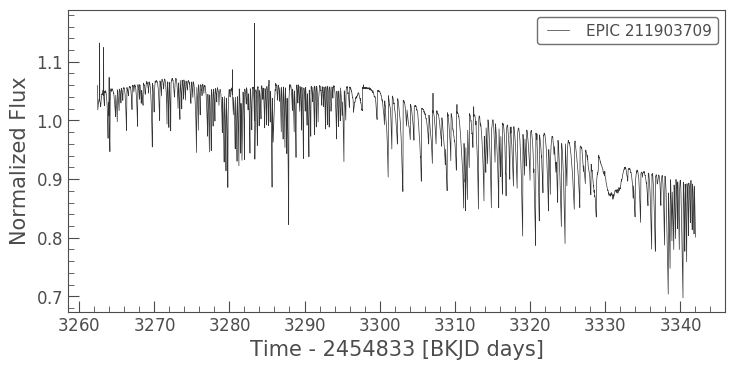

In [5]:
flc.plot()

This is the raw light curve. The is intrumental noise but also stellar variability. Let's remove it with K2SC:

In [ ]:
flc = flc.detrend()

Starting initial outlier detection at 3sigma.
iteration 1 at normalized median flux1.00000 \pm 0.00086
iteration 2 at normalized median flux1.00000 \pm 0.00082
iteration 3 at normalized median flux1.00000 \pm 0.00082
iteration 4 at normalized median flux1.00000 \pm 0.00082
  Flagged 150 ( 4.1%) outliers.
Starting Lomb-Scargle period search
  Using SqrExp position kernel
  Found periodicity p =   12.55 (fap 0.0000e+00 < 1e-50), will use a quasiperiodic kernel
Starting global hyperparameter optimisation using DE
  DE iteration %3i -ln(L) %4.1f 0 -3816.0426743285543
  DE iteration %3i -ln(L) %4.1f 1 -3865.2523130549184
  DE iteration %3i -ln(L) %4.1f 2 -3974.4154578950092
  DE iteration %3i -ln(L) %4.1f 3 -3974.4154578950092
  DE iteration %3i -ln(L) %4.1f 4 -3974.4154578950092


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,6))
plt.plot(flc.time, flc.detrended_flux, c='k')
plt.plot(flc.time, flc.flux, c='c')

**K2SC** preserved flare signal fairly well, so this is what we use for flare finding.

So let us find the flares in this light curve (one, at least, is pretty obvious, right?)

In [ ]:
flc.it_med

In [ ]:
flc = flc.find_flares()
flc.flares

AHA! Four flares! Let's see where they are:

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(flc.time, flc.detrended_flux, c='k', label='detrended flux')
plt.plot(flc.time, flc.it_med, c='c', label='median')
for i,f in flc.flares.iterrows():
    plt.plot(flc.time[f.istart:f.istop+1], flc.detrended_flux[f.istart:f.istop+1], c='r')
#plt.ylim(36500,37500)
plt.xlim(2230,2235)
plt.legend()

No surprise we found the big one. The other three are not that obvious.

Now, what if doubt that these three are real? 

What if it's just outliers and similar sized flares would be lost in the noise? 

Or rest undiscovered due to low time resolution?

Let us test that (may take a moment):

In [ ]:
flc.it_med

In [ ]:
flc = flc.characterize_flares(iterations=100)
flc.flares

The first one is a shaky candidate. We'd recommend not considering any such flares as true events.

The large events are relatively likely flares as we would expect them. Flares with similar equivalent durations (ED)² as the two bigger flares are recovered in >80% of the cases. 

The last one is pretty much lost in the noise and is most likely an outlier that happens to fit the detection criteria¹ (2nd output line). 

We have run an injection recovery procedure, that introduces synthetic flares similar to the one we recovered and tries to find them again. 

The ``flares`` attribute stores the relevant information about each flare as soon as it is found. When we run the ``characterize_flares`` method on our ``FlareLightCurve``, we add the ``ed_rec_corr`` and ``rec_prob``  attributes. ``ed_rec_corr`` gives the ratio between the injected flare's ED and the recovered one in a bin around the observed value (here: 1601 s). ``rec_prob`` is the number of recovered flares relative to all injected ones, or recovery probability - again in a ED bin around the observed flare.

¹detection criteria are listed in the ``find_flares_in_cont_obs_period`` function in the ``altai`` module

²equivalent duration is a proxy for flare energy that is relative to total stellar flux. It is measured in seconds: It is how long the star needs to quietly shine until it has released just as much flux as the flare did.

We can look at what happens, when we inject and recover synthetic flares within **AltaiPony**:

In [ ]:
data, fake_lc = flc.sample_flare_recovery(iterations=10)

``fake_lc`` stores the flux with injected flare event after the last iteration: 

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(fake_lc.time, fake_lc.detrended_flux, c='k')
plt.plot(fake_lc.time, fake_lc.it_med, c='c')
for i,f in fake_lc.flares.iterrows():
    plt.plot(fake_lc.time[f.istart-10:f.istop+50], fake_lc.detrended_flux[f.istart-10:f.istop+50], c='r')

``data`` stores all injected flares, if they were recovered, and if yes, also the recovered ED, just as with real flares.

In [ ]:
data.head()

Flares that overlap are summed up and treated as a single complex flare and the recovered ED is compared to the sum of injected EDs. Re-running ``sample_flare_recovery`` will yield complex flares every once in a while.